In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'lgg-mri-segmentation:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F181273%2F407317%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240531%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240531T162703Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D21a3fa955f90fd5f5f50ae1b2f5920e714e4e9daa24f940c3ce765ce020d058c77ca5e6ac2255af02d6145f47540a656fdee9e79c230a8223caeba93fce652d0ada45d8b3336d5aee23084c1cf2f123ef9e1df14fbfcaefb7adcc0ff1e002e998ece7aec54338ab76b7485857657c7ea6d31e19ab91db644269f8a3ed78fb136ada69bca5fef6e3eca86c99962aae14fde3b4e01a8b9d196ad052a77914a43dc2ef3329d1f3f035a657e6911813601d7f69f0b374ca101086902a49dd736c305ea92a934841fddd26c84ce8c5542cb552e69638b70cda6fa24e789162e865f3329aec2f866dc74302c3579ac1f200660904703df97c493d2cf66b47d9d2272c0'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 748584920 bytes downloaded
Downloaded and uncompressed: lgg-mri-segmentation
Data source import complete.


In [2]:

import tensorflow as tf

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from IPython.display import Image, display


from skimage.color import rgb2gray
from tensorflow.keras import Input, layers
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Add, Multiply, Lambda, Layer
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.losses import binary_crossentropy


from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
im_width = 256
im_height = 256

image_filename_train = []

mask_files = glob(pathname='/kaggle/input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')
for i in mask_files:
    image_filename_train.append(i.replace('_mask',''))


In [4]:
def plot_from_img_path(rows, columns, list_img_path, list_mask_path):
    fig = plt.figure(figsize  = (12,12))
    for i in range(1, rows * columns + 1):
        fig.add_subplot(rows, columns, i)
        img_path = list_img_path[i]
        mask_path = list_mask_path[i]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path)
        plt.imshow(image)
        plt.imshow(mask, alpha=0.5)
    plt.show()

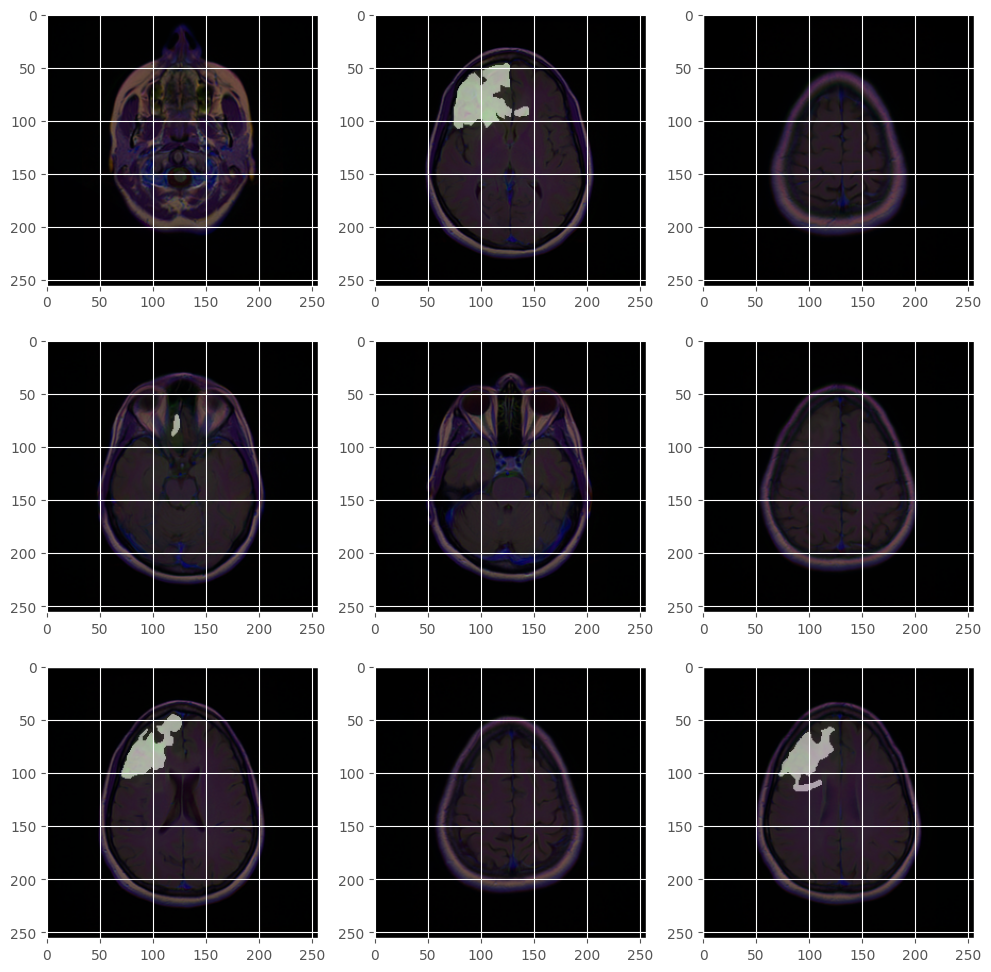

In [5]:
plot_from_img_path(3, 3, image_filename_train, mask_files)

In [6]:
df = pd.DataFrame(data = {'image_filename_train': image_filename_train, 'mask': mask_files})
df_train, df_test = train_test_split(df, test_size = 0.2, random_state=42)
df_train, df_val = train_test_split(df_train, test_size = 0.2, random_state=42)
print(f"Total dataset size: {len(df)}")
print(f"Training set size: {len(df_train)}")
print(f"Validation set size: {len(df_val)}")
print(f"Testing set size: {len(df_test)}")

Total dataset size: 3929
Training set size: 2514
Validation set size: 629
Testing set size: 786


In [7]:
def train_generator(
    data_frame,
    batch_size,
    augmentation_dict,
    image_color_mode="rgb",
    mask_color_mode="grayscale",
    image_save_prefix="image",
    mask_save_prefix="mask",
    save_to_dir=None,
    target_size=(256, 256),
    seed=1,
):

    image_datagen = ImageDataGenerator(**augmentation_dict)
    mask_datagen = ImageDataGenerator(**augmentation_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col="image_filename_train",
        class_mode=None,
        color_mode=image_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=image_save_prefix,
        seed=seed,
    )

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col="mask",
        class_mode=None,
        color_mode=mask_color_mode,
        target_size=target_size,
        batch_size=batch_size,
        save_to_dir=save_to_dir,
        save_prefix=mask_save_prefix,
        seed=seed,
    )

    train_gen = zip(image_generator, mask_generator)

    def normalize_and_diagnose(img, mask):
        img = img / 255
        mask = mask / 255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
        return(img, mask)

    # Final return Tuple after image Normalization and Diagnostics
    for (img, mask) in train_gen:
        img, mask = normalize_and_diagnose(img, mask)
        yield (img, mask)

In [8]:

@tf.keras.utils.register_keras_serializable()
def dice_coefficients(y_true, y_pred, smooth=1e-5):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)

    intersection = K.sum(y_true_flatten * y_pred_flatten)
    union = K.sum(y_true_flatten) + K.sum(y_pred_flatten)
    return (2 * intersection + smooth) / (union + smooth)

@tf.keras.utils.register_keras_serializable()
def dice_coefficients_loss(y_true, y_pred, smooth=1):
    return 1 -dice_coefficients(y_true, y_pred, smooth)

@tf.keras.utils.register_keras_serializable()
def combined_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_coefficients_loss(y_true, y_pred)

@tf.keras.utils.register_keras_serializable()
def iou(y_true, y_pred, smooth=1e-5):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)

    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3]) - intersection

    iou = (intersection + smooth) / (union + smooth)

    return K.mean(iou)





In [9]:
def unet(input_size=(im_width,im_height, 3)):
    inputs = Input(input_size)

    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(inputs)
    bn1 = Activation("relu")(conv1)
    conv1 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation("relu")(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(pool1)
    bn2 = Activation("relu")(conv2)
    conv2 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation("relu")(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(pool2)
    bn3 = Activation("relu")(conv3)
    conv3 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation("relu")(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(pool3)
    bn4 = Activation("relu")(conv4)
    conv4 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation("relu")(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(pool4)
    bn5 = Activation("relu")(conv5)
    conv5 = Conv2D(filters=1024, kernel_size=(3, 3), padding="same")(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation("relu")(bn5)


    up6 = concatenate([Conv2DTranspose(512, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn5), conv4], axis=3)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(up6)
    bn6 = Activation("relu")(conv6)
    conv6 = Conv2D(filters=512, kernel_size=(3, 3), padding="same")(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation("relu")(bn6)

    up7 = concatenate([Conv2DTranspose(256, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn6), conv3], axis=3)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(up7)
    bn7 = Activation("relu")(conv7)
    conv7 = Conv2D(filters=256, kernel_size=(3, 3), padding="same")(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation("relu")(bn7)

    up8 = concatenate([Conv2DTranspose(128, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn7), conv2], axis=3)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(up8)
    bn8 = Activation("relu")(conv8)
    conv8 = Conv2D(filters=128, kernel_size=(3, 3), padding="same")(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation("relu")(bn8)

    up9 = concatenate([Conv2DTranspose(64, kernel_size=(2, 2), strides=(2, 2), padding="same")(bn8), conv1], axis=3)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(up9)
    bn9 = Activation("relu")(conv9)
    conv9 = Conv2D(filters=64, kernel_size=(3, 3), padding="same")(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation("relu")(bn9)

    conv10 = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(bn9)

    return Model(inputs=[inputs], outputs=[conv10])

In [10]:
EPOCHS = 50
BATCH_SIZE = 32


train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))

test_gener = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))

model = unet(input_size=(im_height, im_width, 3))
model.summary()


# decay_rate = learning_rate / EPOCHS


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['activation[0][0]']          
                                                                                              

In [11]:
model.compile(optimizer='adam', loss=combined_loss, metrics=["binary_accuracy", iou, dice_coefficients])

checkpoint = ModelCheckpoint('unet_brain_mri_seg1.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')

history = model.fit(train_gen,
                    steps_per_epoch=int(len(df_train) / BATCH_SIZE),
                    epochs=EPOCHS,
                    validation_data=test_gener,
                    callbacks=[checkpoint, early_stopping],
                    validation_steps=int(len(df_val) / BATCH_SIZE))

Found 2514 validated image filenames.
Found 2514 validated image filenames.
Epoch 1/50
78/78 [==============================] - ETA: 0s - loss: 0.9520 - binary_accuracy: 0.9724 - iou: 0.5410 - dice_coefficients: 0.1763Found 629 validated image filenames.
Found 629 validated image filenames.

Epoch 1: val_loss improved from inf to 2.33830, saving model to unet_brain_mri_seg1.keras
78/78 [==============================] - 226s 2s/step - loss: 0.9520 - binary_accuracy: 0.9724 - iou: 0.5410 - dice_coefficients: 0.1763 - val_loss: 2.3383 - val_binary_accuracy: 0.5816 - val_iou: 0.0649 - val_dice_coefficients: 0.0399
Epoch 2/50
78/78 [==============================] - ETA: 0s - loss: 0.5738 - binary_accuracy: 0.9913 - iou: 0.6781 - dice_coefficients: 0.4672
Epoch 2: val_loss did not improve from 2.33830
78/78 [==============================] - 207s 2s/step - loss: 0.5738 - binary_accuracy: 0.9913 - iou: 0.6781 - dice_coefficients: 0.4672 - val_loss: 25.7889 - val_binary_accuracy: 0.1628 - va

In [12]:
model = load_model('unet_brain_mri_seg1.keras', custom_objects={
    'dice_coefficients': dice_coefficients,
    'dice_coefficients_loss': dice_coefficients_loss,
    'combined_loss': combined_loss,
    'iou': iou
})

In [13]:
test_gen = train_generator(df_test, BATCH_SIZE, dict(), target_size=(im_height,im_width))

results = model.evaluate(test_gen, steps = int(len(df_test)/BATCH_SIZE))
print('Test Loss', results[0])
print('Test IOU', results[2])
print('Test Dice Coeff', results[3])

Found 786 validated image filenames.
Found 786 validated image filenames.
24/24 [==============================] - 13s 525ms/step - loss: 0.1562 - binary_accuracy: 0.9973 - iou: 0.8466 - dice_coefficients: 0.8575
Test Loss 0.15623846650123596
Test IOU 0.8465744853019714
Test Dice Coeff 0.8574998378753662


1/1 [==============================] - 3s 3s/step


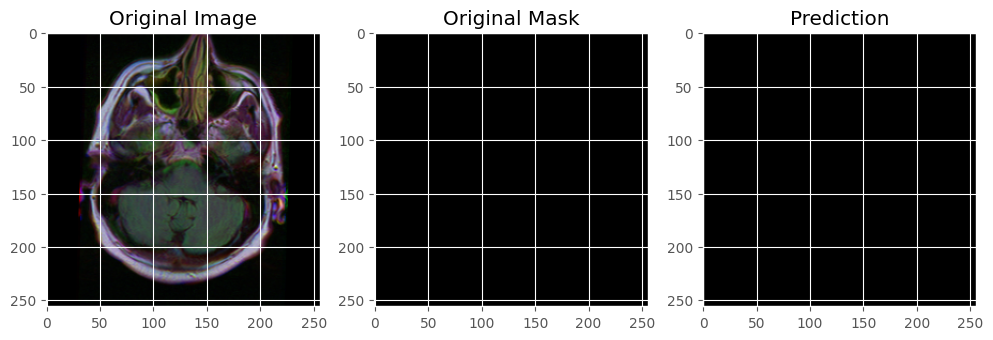

1/1 [==============================] - 0s 20ms/step


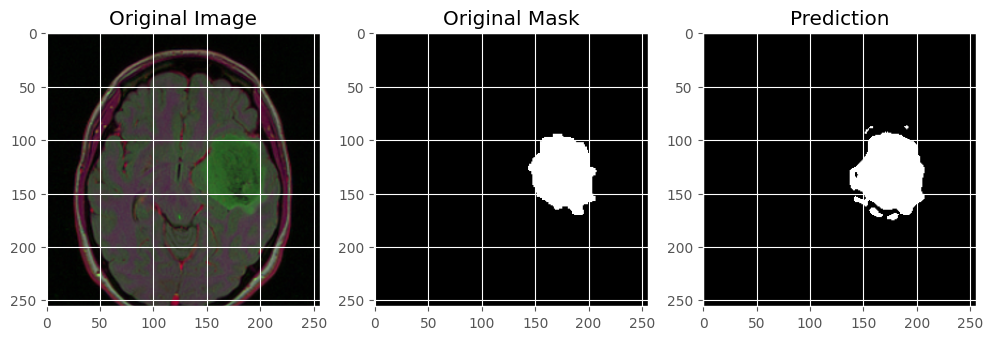

1/1 [==============================] - 0s 20ms/step


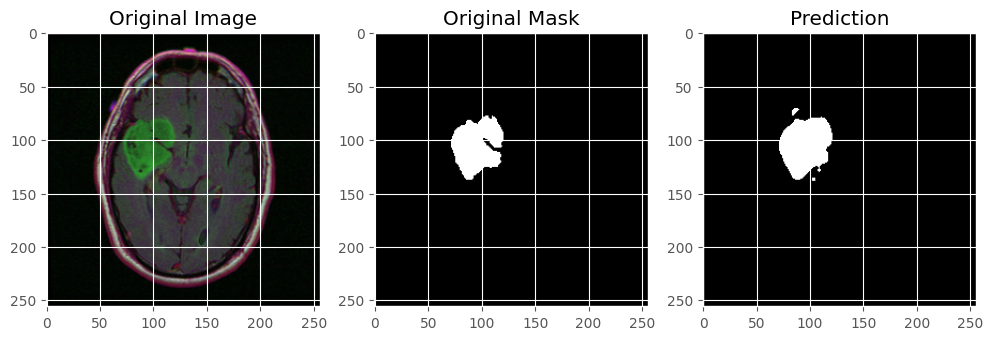

1/1 [==============================] - 0s 26ms/step


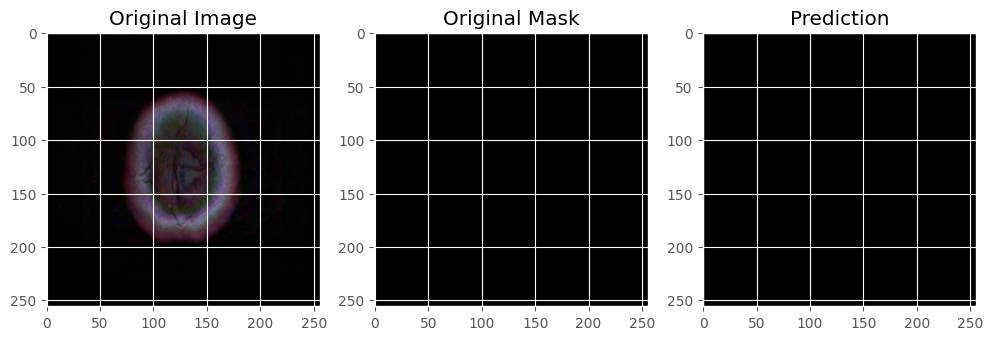

1/1 [==============================] - 0s 21ms/step


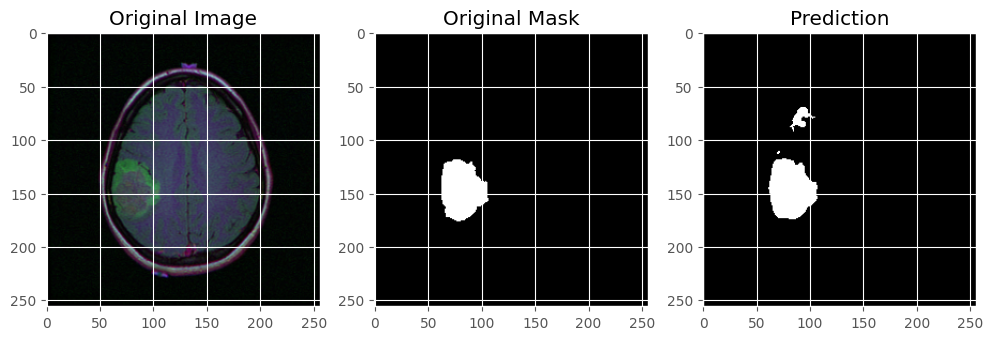

1/1 [==============================] - 0s 43ms/step


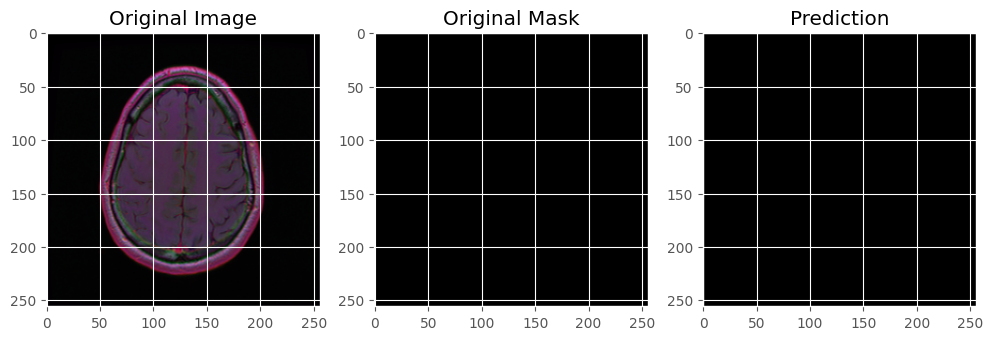

1/1 [==============================] - 0s 33ms/step


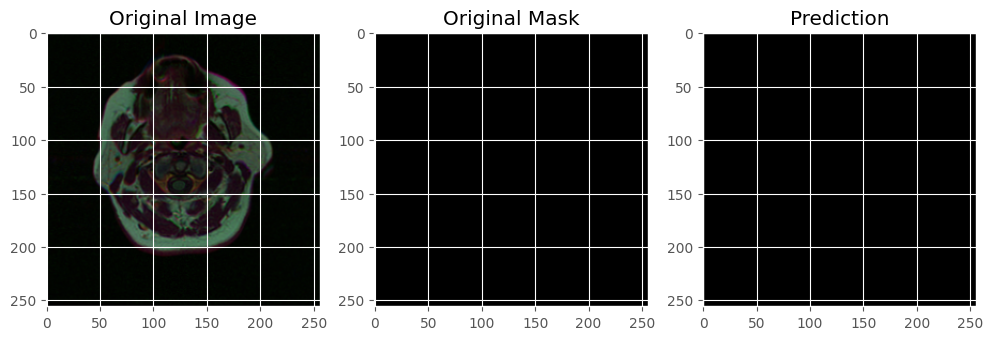

1/1 [==============================] - 0s 45ms/step


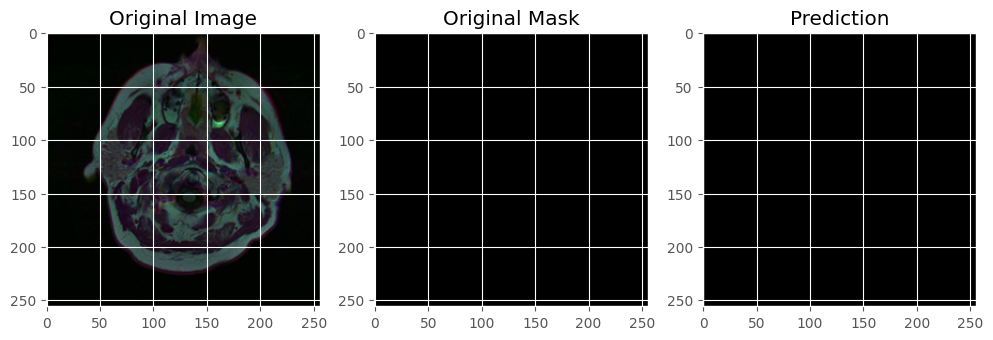

1/1 [==============================] - 0s 30ms/step


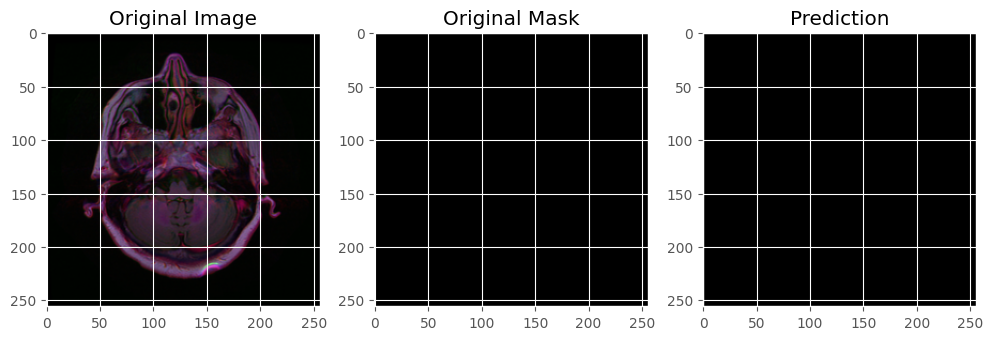

1/1 [==============================] - 0s 19ms/step


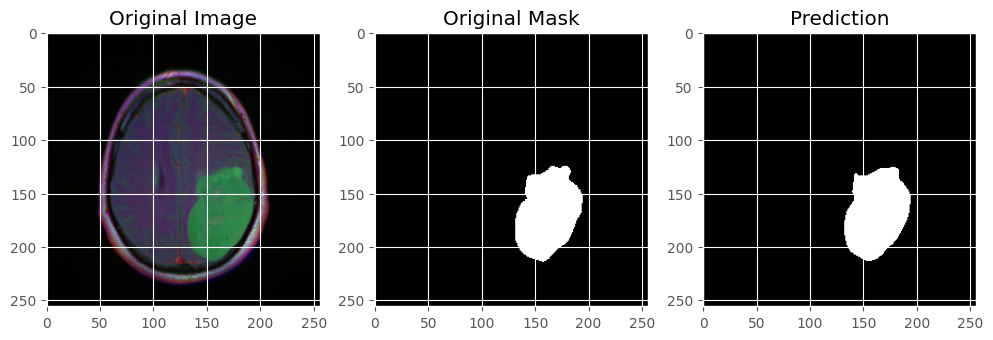

In [14]:
for i in range(10):
    index = np.random.randint(1, len(df_test.index))
    img = cv2.imread(df_test['image_filename_train'].iloc[index])
    img = cv2.resize(img, (im_height,im_width))
    img = img/255
    img = img[np.newaxis, : ,:, :]
    pred_img = model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1, 3, 1)
    plt.imshow(np.squeeze(img))
    plt.title("Original Image")
    plt.subplot(1, 3, 2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title("Original Mask")
    plt.subplot(1, 3, 3)
    plt.imshow(np.squeeze(pred_img>0.5), cmap='gray')
    plt.title("Prediction")
    plt.show()

In [15]:
images_with_tumor = []
images_without_tumor = []

# Iterate over each image and mask in df_test
for idx, row in df_test.iterrows():
    image_path = row['image_filename_train']
    mask_path = row['mask']

    # Load the mask
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    # Check if the mask has any white regions
    if np.any(mask > 0):  # There is a white region in the mask
        images_with_tumor.append(image_path)
    else:  # The mask is completely black
        images_without_tumor.append(image_path)

# Display the count of images in each category
print(f'Images with tumor: {len(images_with_tumor)}')
print(f'Images without tumor: {len(images_without_tumor)}')

Images with tumor: 281
Images without tumor: 505


Images with Tumors:


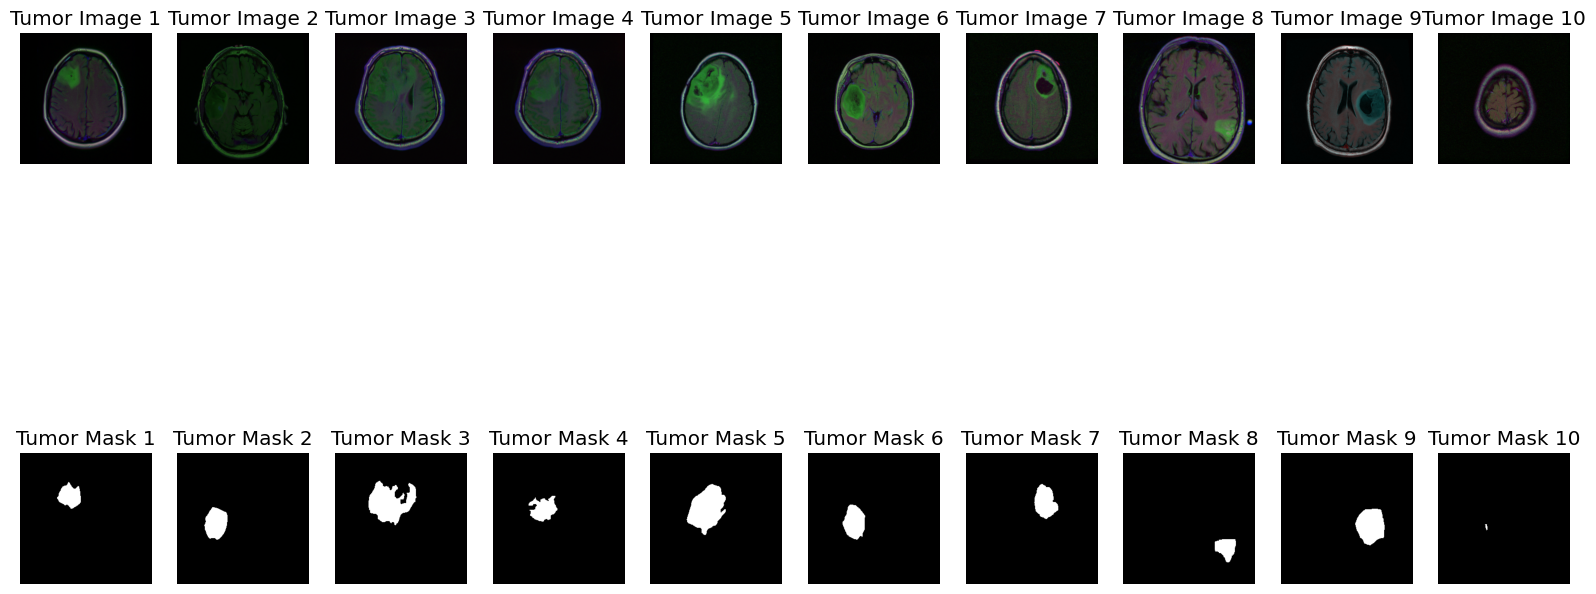

Images without Tumors:


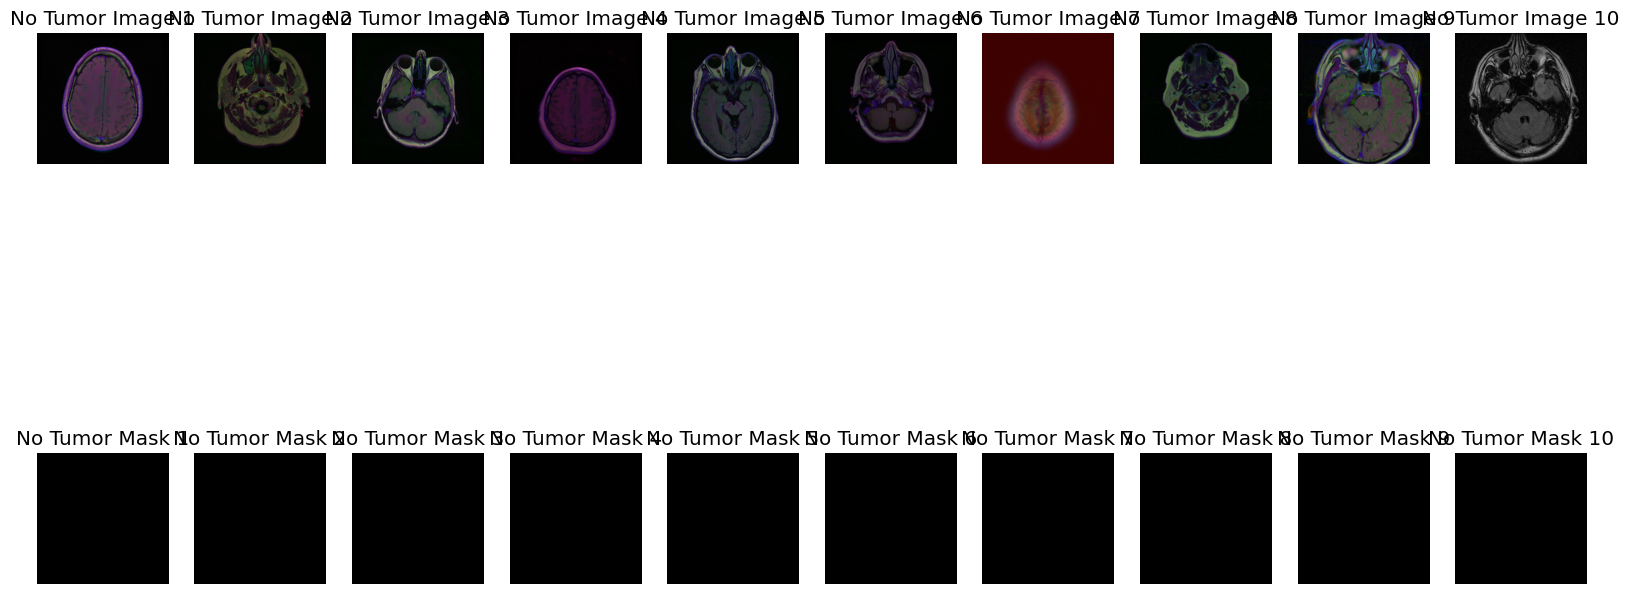

In [16]:
num_images_to_show = 10

# Randomly select 10 images from each category
random_images_with_tumor = random.sample(images_with_tumor, min(num_images_to_show, len(images_with_tumor)))
random_images_without_tumor = random.sample(images_without_tumor, min(num_images_to_show, len(images_without_tumor)))

def display_images_with_masks(image_paths, mask_paths, title):
    plt.figure(figsize=(20, 10))
    for i, (image_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        plt.subplot(2, num_images_to_show, i + 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f'{title} Image {i + 1}')
        plt.axis('off')

        plt.subplot(2, num_images_to_show, i + 1 + num_images_to_show)
        plt.imshow(mask, cmap='gray')
        plt.title(f'{title} Mask {i + 1}')
        plt.axis('off')
    plt.show()

# Collect the corresponding mask paths for the selected images
mask_paths_with_tumor = [df_test.loc[df_test['image_filename_train'] == img, 'mask'].values[0] for img in random_images_with_tumor]
mask_paths_without_tumor = [df_test.loc[df_test['image_filename_train'] == img, 'mask'].values[0] for img in random_images_without_tumor]

# Display images with tumors
print("Images with Tumors:")
display_images_with_masks(random_images_with_tumor, mask_paths_with_tumor, 'Tumor')

# Display images without tumors
print("Images without Tumors:")
display_images_with_masks(random_images_without_tumor, mask_paths_without_tumor, 'No Tumor')

1/1 [==============================] - 0s 20ms/step


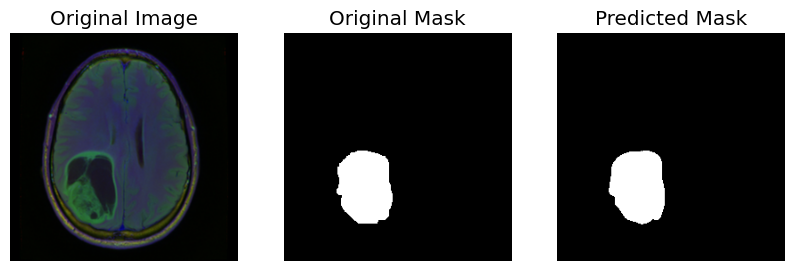

In [22]:
index = np.random.randint(0, len(df_test.index))
image_path = df_test['image_filename_train'].iloc[index]
image = cv2.imread(image_path)
image_resized = cv2.resize(image, (256, 256))  # Resize image to 256x256
image_normalized = image_resized / 255.0  # Normalize to [0, 1]
image_input = np.expand_dims(image_normalized, axis=0)  # Add batch dimension

# Predict the mask
predicted_mask = model.predict(image_input)[0]

# Apply a threshold to get a binary mask
threshold = 0.5
binary_mask = (predicted_mask > threshold).astype(np.uint8)

# Display the original image and the predicted mask
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.subplot(1, 3, 2)
plt.title("Original Mask")
plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
plt.axis('off')
plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(binary_mask, cmap='gray')
plt.axis('off')

plt.show()

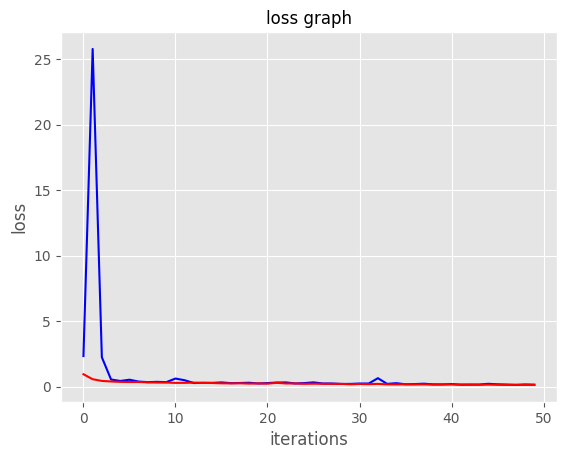

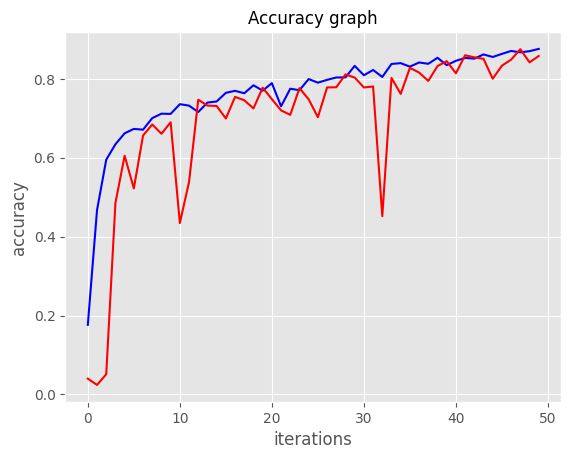

In [23]:
history_post_training = history.history

train_dice_coeff_list = history_post_training['dice_coefficients']
test_dice_coeff_list = history_post_training['val_dice_coefficients']

train_jaccard_list = history_post_training['iou']
test_jaccard_list = history_post_training['val_iou']

train_loss_list = history_post_training['loss']
test_loss_list = history_post_training['val_loss']

plt.figure(1)
plt.plot(test_loss_list, 'b-')
plt.plot(train_loss_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('loss')
plt.title('loss graph', fontsize=12)

plt.figure(2)
plt.plot(train_dice_coeff_list, 'b-')
plt.plot(test_dice_coeff_list, 'r-')

plt.xlabel('iterations')
plt.ylabel('accuracy')
plt.title('Accuracy graph', fontsize=12)
plt.show()